# Medical Image Segmentation: Registration

Please first check if simple itk packages is installed (https://simpleitk.org/). In this assignment, you will be asked to test image registration onf lung field images

Note that you are ALLOWED to use functions from scipy, matplotlib, simple itk, and numpy Python packages.

# Database

The function below shows how to open and visualize a lung X-ray using simple itk. Please be sure that you correctly specified the path to the data for this assignment.

In [ ]:
!pip install SimpleITK
# !unzip '/content/drive/MyDrive/MIA/assignment3/Hand_In_3.zip' -d '/content/drive/MyDrive/MIA/assignment3/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 156 kB/s 


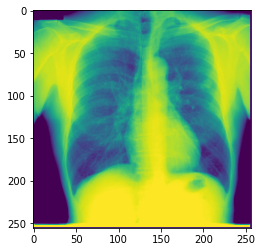

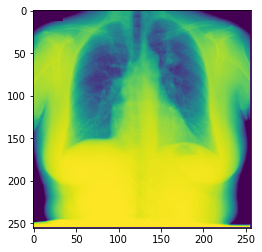

In [3]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageSequence

folder = "D:/MIA/handin3/data/"

im1 = sitk.ReadImage(folder + "images/JPCLN001.bmp", sitk.sitkFloat32)
im2 = sitk.ReadImage(folder + "images/JPCLN003.bmp", sitk.sitkFloat32)

plt.figure(1)
imgplot = plt.imshow(sitk.GetArrayFromImage(im1))
plt.figure(2)
imgplot = plt.imshow(sitk.GetArrayFromImage(im2))

# Exercise 1

Please use simple itk to implement 2D image registration. Here is the example of how to do that https://simpleitk.readthedocs.io/en/v1.1.0/Examples/ImageRegistrationMethod1/Documentation.html. Check also this link https://simpleitk.org/SPIE2019_COURSE/04_basic_registration.html

Note that your function should return two objects: a) transformed image and b) transformation field

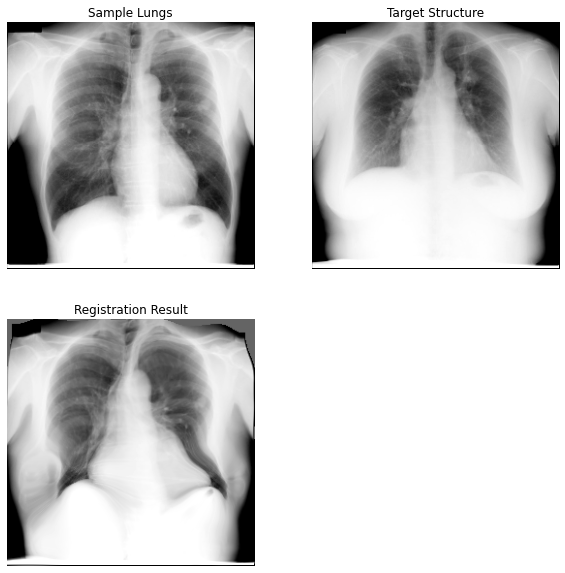

In [22]:
def set_non_rigid_transform(R, im_fixed):
    # this function should be called instead of R.SetInitialTransform
    mesh_size= [int(im_fixed.GetSize()[0] / 20), int(im_fixed.GetSize()[1] / 20)]
    initial_transform = sitk.BSplineTransformInitializer(image1 = im_fixed, 
                                                         transformDomainMeshSize = mesh_size, order = 2)   
    
    transformDomainMeshSize = [2] * im_fixed.GetDimension()
    #print (transformDomainMeshSize)
    tx = sitk.BSplineTransformInitializer(im_fixed,
                                          transformDomainMeshSize )
    R.SetInitialTransformAsBSpline(initial_transform,
                                   inPlace = True,
                                   scaleFactors=[1,2,5])

# this funciton should use moving image im_moving to compute the transformation matrix outTx 
# that will align im_moving with im_fixed
def registration(im_moving, im_fixed):
    
    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsMeanSquares()
    R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200 )
    set_non_rigid_transform(R,im_fixed) #- this should be run just before SetInterpolator
    outTx = R.Execute(im_fixed, im_moving)

    return outTx # this is transformation between images

# this function applies transformation to im_to_transform using transformation outTx
# im_fixed is needed to know the output size
def transform_image(im_to_transform, im_fixed, outTx):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(im_fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)
    out = resampler.Execute(im_to_transform)

    return out # this is the deformed im_to_transform
    
    
outTx = registration(im1, im2)
transformed_image = transform_image(im1, im2, outTx)

fig = plt.figure(figsize=(10,10))

rows = 2
columns = 2



fig.add_subplot(rows,columns,1)
plt.imshow(sitk.GetArrayFromImage(im1), cmap=plt.cm.gray)
plt.axis('off')
plt.title("Sample Lungs")

fig.add_subplot(rows,columns,2)
plt.imshow(sitk.GetArrayFromImage(im2), cmap=plt.cm.gray)
plt.axis('off')
plt.title("Target Structure")

fig.add_subplot(rows,columns,3)
plt.imshow(sitk.GetArrayFromImage(transformed_image), cmap=plt.cm.gray)
plt.axis('off')
plt.title("Registration Result")

'''
fig.add_subplot(rows,columns,4)
plt.imshow(outTx, cmap=plt.cm.gray)
plt.axis('off')
plt.title("d")
'''
plt.show()



# Exercise 2

In this exercise you will try atlas-based segmentation of a lung field image. Please use the following code to read the training and testing images with the masks

In [ ]:
test_im = sitk.ReadImage(folder + "images/JPCLN001.bmp", sitk.sitkFloat32)
# test_mask = sitk.ReadImage(folder + "fold1/masks/left lung/JPCLN001.bmp", sitk.sitkFloat32)
test_mask=sitk.GetImageFromArray(np.array(Image.open(folder + "fold1/masks/left lung/JPCLN001.gif").resize((256,256))))


train_ims = []
train_ims.append(sitk.ReadImage(folder + "images/JPCLN003.bmp", sitk.sitkFloat32))
train_ims.append(sitk.ReadImage(folder + "images/JPCLN005.bmp", sitk.sitkFloat32))
train_ims.append(sitk.ReadImage(folder + "images/JPCLN007.bmp", sitk.sitkFloat32))
train_ims.append(sitk.ReadImage(folder + "images/JPCLN009.bmp", sitk.sitkFloat32))


train_masks = []
train_masks.append(sitk.GetImageFromArray(np.array(Image.open(folder + "fold1/masks/left lung/JPCLN003.gif").resize((256,256)))))
train_masks.append(sitk.GetImageFromArray(np.array(Image.open(folder + "fold1/masks/left lung/JPCLN005.gif").resize((256,256)))))
train_masks.append(sitk.GetImageFromArray(np.array(Image.open(folder + "fold1/masks/left lung/JPCLN007.gif").resize((256,256)))))
train_masks.append(sitk.GetImageFromArray(np.array(Image.open(folder + "fold1/masks/left lung/JPCLN009.gif").resize((256,256)))))

[2, 2]
[2, 2]
[2, 2]
[2, 2]
(256, 256)


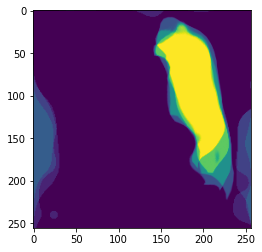

In [ ]:
# this function runs an atlas-based segmneation of lung fields
def atlas_registration(test_im, train_ims, train_masks):
    # create the result array where the atlas results will be accumulated
    result = np.zeros(sitk.GetArrayFromImage(im1).shape)
    for i in range(0, len(train_ims)):
        outTx = registration(train_ims[i], test_im)
        # transformed_image = transform_image(train_ims[i], test_im, outTx)
        transformed_mask = transform_image(train_masks[i], test_im, outTx)
        # trans_image_array = sitk.GetArrayFromImage(transformed_image)
        trans_mask_array = sitk.GetArrayFromImage(transformed_mask)
        ids = np.argwhere(trans_mask_array!=0)
        for id in ids:
          result[id[0],id[1]] += trans_mask_array[id[0],id[1]]
    result = result / len(train_ims)
    return np.asarray(result)

atlas_result = atlas_registration(test_im, train_ims, train_masks)
print(atlas_result.shape)
imgplot = plt.imshow(atlas_result)

Use code from previous exerices to compute the Dice coefficient between the reference mask 'test_mask' and the result of atlas-based segmentation 'atlas_result'.

0.8770724774988157


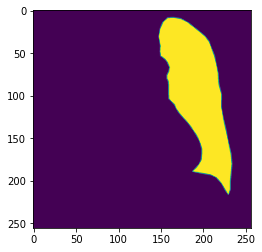

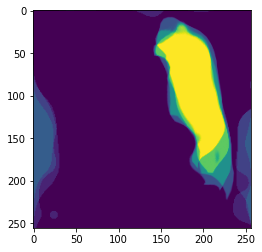

In [ ]:
def compute_dice(test_mask, atlas_result):
    #TP, FP, FN = 0
    TP = np.sum(np.logical_and(atlas_result >= 0.5, test_mask == 1))
    FP = np.sum(np.logical_and(atlas_result < 0.5, test_mask == 1))
    FN = np.sum(np.logical_and(atlas_result >= 0.5, test_mask == 0))
    return 2 * TP / (2 * TP + FP + FN)



plt.figure(1)
imgplot = plt.imshow(sitk.GetArrayFromImage(test_mask))
plt.figure(2)
imgplot = plt.imshow(atlas_result)

test_mask = (test_mask / np.amax(test_mask)) > 0.5
atlas_result = (atlas_result / np.amax(atlas_result)) > 0.5
print(compute_dice(sitk.GetArrayFromImage(test_mask), atlas_result))